# Imports

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision import datasets, transforms ,models
from torch.cuda.amp import GradScaler ,autocast
from IPython import display
import gc 

import os
import re
from shutil import copyfile
import copy

from __future__ import print_function
from PIL import Image
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/gdrive') #MyDeive

# import torchinfo 
torch.cuda.empty_cache()
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.cuda.get_device_name(0)
#device

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Download Kaggle Data set 

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip -qq "/content/test.csv.zip" -d "/content/"
!unzip -qq "/content/train.csv.zip" -d "/content/"

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 11.9MB/s]
 84% 81.0M/96.6M [00:01<00:00, 43.0MB/s]
100% 96.6M/96.6M [00:01<00:00, 55.4MB/s]
 67% 13.0M/19.3M [00:00<00:00, 29.4MB/s]
100% 19.3M/19.3M [00:00<00:00, 35.7MB/s]
 90% 83.0M/92.0M [00:02<00:00, 43.8MB/s]
100% 92.0M/92.0M [00:02<00:00, 45.3MB/s]
 94% 73.0M/77.3M [00:01<00:00, 66.5MB/s]
100% 77.3M/77.3M [00:01<00:00, 75.9MB/s]


**If u want to load model parameters from Github**

In [35]:
# !wget "https://github.com/Mohamed-El-Kasaby/CV/raw/main/Computer%20Vesion%20on%20colab/Best_model_on_valdtion.zip"
# !unzip "/content/Best_model_on_valdtion.zip"

# Generate Data folders and Save images

In [24]:
class Generate_data():
    def __init__(self, datapath):
        """
        Generate_data class
        Two methods to be used
        1-split_test
        2-save_images
        [Note] that you have to split the public and private from fer2013 file
        """
        self.data_path = datapath

    def split_test(self, test_filename = 'finaltest', val_filename= 'val'):
        """
        Helper function to split the validation and test data from general test file as it contains (Public test, Private test)
            params:-
                data_path = path to the folder that contains the test data file
        """
        csv_path = self.data_path +"/"+ 'test.csv'
        train_csv = self.data_path +"/"+ 'train.csv'
        test = pd.read_csv(csv_path)
        train = pd.read_csv(train_csv)
        validation_data = pd.DataFrame(train.iloc[:3589,:])
        train  = pd.DataFrame(train.iloc[3589:,:])
        test_data = pd.DataFrame(test.iloc[3589:,:])
        # validation_data.columns = ['emotion', "pixels"]
        test_data.to_csv(self.data_path+"/"+test_filename+".csv")
        validation_data.to_csv(self.data_path+"/"+val_filename+".csv")
        train.to_csv(self.data_path+"/"+"train"+".csv")
        print("Done splitting the test file into validation & final test file")

    def str_to_image(self, str_img = ' '):
        '''
        Convert string pixels from the csv file into image object
            params:- take an image string
            return :- return PIL image object
        '''
        imgarray_str = str_img.split(' ')
        imgarray = np.repeat(np.asarray(imgarray_str,dtype=np.uint8).reshape(48,48)[...,np.newaxis],3,-1)
        return Image.fromarray(imgarray)

    def save_images(self, datatype='train'):
        '''
        save_images is a function responsible for saving images from data files e.g(train, test) in a desired folder
            params:-
            datatype= str e.g (train, val, finaltest)
        '''
        datatype = datatype
        foldername= self.data_path+"/"+datatype
        csvfile_path= self.data_path+"/"+datatype+'.csv'
        if not os.path.exists(foldername):
            os.mkdir(foldername)

        data = pd.read_csv(csvfile_path)
        images = data['pixels'] #dataframe to series pandas
        numberofimages = images.shape[0]
        mapper ={0 : "Angry", 1 : "Disgust", 2 : "Fear", 3 : "Happy",
                 4 : "Sad", 5 : "Surprise", 6 : "Neutral"}
        if  datatype =='train' or datatype == 'val' :
          for i in mapper:
            emo_folder = self.data_path+"/"+datatype+"/"+mapper[i]
            if not os.path.exists(emo_folder):
              os.mkdir(emo_folder)
              
          for index in tqdm(range(numberofimages)):
              img = self.str_to_image(images[index])
              img.save(os.path.join(foldername+"/"+mapper[data['emotion'][index]],'{}{}.jpg'.format(datatype,index)),'JPEG')
          print('Done saving {} data'.format((foldername)))
          # pass
        elif datatype != 'train' or datatype != 'val' :
          foldername= self.data_path+"/"+datatype
          csvfile_path= self.data_path+"/"+datatype+'.csv'
          if not os.path.exists(foldername):
              os.mkdir(foldername)

          data = pd.read_csv(csvfile_path)
          images = data['pixels'] #dataframe to series pandas
          numberofimages = images.shape[0]
          for index in tqdm(range(numberofimages)):
              img = self.str_to_image(images[index])
              img.save(os.path.join(foldername,'{}{}.jpg'.format(datatype,index)),'JPEG')
          print('Done saving {} data'.format((foldername)))


In [12]:
generate_dataset = Generate_data('/content')
generate_dataset.split_test()

# val  = pd.read_csv("/content/val.csv")
# val.columns = ['emotion', "pixels"]
# val.to_csv('val.csv')

generate_dataset.save_images()
generate_dataset.save_images('finaltest')
generate_dataset.save_images('val')

Done splitting the test file into validation & final test file


100%|██████████| 28709/28709 [00:24<00:00, 1159.14it/s]


Done saving /content/train data


100%|██████████| 3589/3589 [00:02<00:00, 1203.98it/s]


Done saving /content/finaltest data


100%|██████████| 3589/3589 [00:03<00:00, 1139.36it/s]

Done saving /content/val data


# Function to count number of parameters

In [13]:
def Model_Info(model,summary =False ):
    prams=0
    for p in list(model.parameters()):
        prams += p.nelement()
    print(f'model parameters: {np.round(prams/10**6,2)} M')
    print(torchinfo.summary(model)) if summary else ''

# Function To Load Data

In [14]:
def load_date(transformtions ,batch_size=32, shuffle=True,Set ='train',verbose = True):
    PATH = '/content/'
    data_dir = PATH + Set 
    dataset = datasets.ImageFolder(data_dir, transform=transformtions) 
    if verbose:
        print(f'''Found {len(dataset.samples)} image for {len(dataset.classes)} classes: {", ".join(dataset.classes)},
Each class has label {", ".join([f"{k}: {v}" for k,v in dataset.class_to_idx.items()])}.''')
    #data.random_split
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle ,num_workers=2) 
    
    return dataloader


# Model Creation

In [15]:
def creat_Model(out_features , pretrained=True):
    model= models.mobilenet_v2(pretrained=True)
    model.classifier =  nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                                      nn.Linear(in_features=1280, out_features=out_features, bias=True),
                                      nn.LogSoftmax(dim = 1))
    return model

# Mixed Functions

In [33]:
def opt_Step(x,y,loss_criterion,passed_model):
    # Compute the loss and accuracy
    optimizer.zero_grad()
    # scores
    with autocast():
        y_pred = passed_model(x)
        loss = loss_criterion(y_pred, y)
    
    S, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() /len(y)
    del S
    # one steps
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    return loss.detach().item(),acc.detach().cpu().numpy()

        
#---------------------------------------------------------
def save_best_model(best_metric,current_metric,name,epoch):
    if current_metric > best_metric:
        state = {
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }
        torch.save(state, name+'.pt')
        best_metric = current_metric
        print(f"%s is Saved with metric :%.3f" % (str(name).replace("_"," "),best_metric ))
    return best_metric
################################################
def load_the_model(check_point):
  print("==> Lading the mmodel...")
  model.load_state_dict(check_point['state_dict'])
  optimizer.load_state_dict(check_point['optimizer'])
#---------------------------------------------------------
def valdtion_score(loader,loss_criterion):
    model.eval() 
    loss,acc = 0,0
    steps=len(loader)
    for (X_val ,y_val) in loader_val:
        X_val ,y_val = X_val.to(device) ,y_val.to(device)
        with autocast():
            pred = model(X_val)
            l = loss_criterion(pred, y_val)
        loss += l.detach().cpu().item()
        s ,pred = torch.max(pred, 1)
        acc = acc+ (y_val == pred).sum().cpu().numpy()/len(y_val)
        del s,l, X_val,y_val, pred
    torch.cuda.empty_cache()
    return  loss/steps,acc/steps
#---------------------------------------------------------
def model_data_montor(loader , passed_model ): 
    eval("passed_model") #.eval()
    y_df = pd.DataFrame(columns= ["Y_True","Y_pred"])
    for (x ,y) in loader: 
        y = y.cpu().numpy().reshape(-1)
        pred = eval( f'{passed_model}(x.to(device)).detach().cpu().numpy()')
        del x 
        torch.cuda.empty_cache()
        pred = pred.argmax(1).reshape(-1)
        y_df = y_df.append(pd.DataFrame(np.vstack((y,pred )).T, columns=y_df.columns), ignore_index=True)
        del  pred , y 
    y_df["eq"] = (y_df["Y_True" ] == y_df["Y_pred" ])
    mapper ={0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger',
                7: 'Contempt'}
    y_df["Y_True" ] = y_df["Y_True" ].map(mapper) 
    y_df["Y_pred" ] = y_df["Y_pred"].map(mapper) 

    g= y_df.groupby(['Y_True','eq'])\
            .agg('size').div(y_df.shape[0])\
            .sort_index( ascending=[True,False]).unstack()

    plt.rc('font', **{'size'   : 13})
    print(f'Accuracy : {g.sum(0).values[1]} ,Error:{g.sum(0).values[0]} ')
    fig,ax=plt.subplots(1,2,figsize = (22,7))
    ConfusionMatrixDisplay(confusion_matrix(y_df["Y_True" ], y_df["Y_pred" ] ,normalize ='true' )
                          ,display_labels=list(mapper.values()) ).plot(ax=ax[0], xticks_rotation= 45)
    ax[0].set_title("Confusion Matrix")#,font ={'weight' : 'bold'}
    ax[0].set_xlabel('Predictions Emotions')
    ax[0].set_ylabel('Actual Emotions')
    sns.heatmap(g,annot=True,ax=ax[1])
    ax[1].tick_params(axis='y', rotation=0)
    ax[1].set_xlabel('Predictions')
    ax[1].set_ylabel('Emotions')
    ax[1].set_title("Error / Accuracy for each Class")
    plt.show()
    del g, fig,ax, y_df
    torch.cuda.empty_cache()
    return None
#---------------------------------------------------------

# Parameters

In [28]:
epoch =1
batchsize= 64
best_metric =0
learning_rate = 5e-3
lambda_l2 = 1e-6

log_loss= np.empty((epoch,3))
log_acc= np.empty((epoch,3))

load_model = True

# Preper Models

In [29]:
transform_trian = transforms.Compose([transforms.ToTensor()
                                                           ])# TODO: compose transforms here
transform_val= transforms.Compose([transforms.ToTensor()
                                                            ])# TODO: compose transforms here
loader_train =load_date(batch_size=batchsize, shuffle=True,transformtions = transform_trian,Set ='train',verbose = True)
loader_val =load_date(batch_size=batchsize, shuffle=True,transformtions = transform_val,Set ='val',verbose = True)

steps_per_ep =len(loader_train)

Found 28709 image for 7 classes: Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise,
Each class has label Angry: 0, Disgust: 1, Fear: 2, Happy: 3, Neutral: 4, Sad: 5, Surprise: 6.
Found 3589 image for 7 classes: Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise,
Each class has label Angry: 0, Disgust: 1, Fear: 2, Happy: 3, Neutral: 4, Sad: 5, Surprise: 6.


In [41]:
input_size  = (48, 48)   # images are 224* 224 pixels
output_size = 7

model =creat_Model(output_size , pretrained=True).to(device)       
criterion = torch.nn.CrossEntropyLoss(  reduction="mean")
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate,betas=(0.9, 0.999)) # built-in L2

#Load weights from Google drive
model_weights = "Best_model_on_valdtion.pt"
my_model = "/content/gdrive/MyDrive/" + model_weights
if load_model:
  load_the_model(torch.load(my_model))
  
Model_Info(model,summary=False)


==> Lading the mmodel...
model parameters: 2.23 M


In [31]:
scaler = GradScaler()
for t in range(1,epoch+1): 
    loss_ep ,acc_ep = 0,0
    batch_indx =0
    model.train()
    for (X ,y) in tqdm(loader_train):
        batch_indx +=1
        X ,y = X.to(device) ,y.to(device) 
        loss ,acc = opt_Step(X,y,criterion,model)
        loss_ep ,acc_ep =  loss_ep + (loss/steps_per_ep), acc_ep+ (acc/steps_per_ep)
        X ,y =X.detach().cpu() ,y.detach().cpu()
        del X, y,loss ,acc
        gc.collect()
        torch.cuda.empty_cache()
        
        
    loss_val ,acc_val = valdtion_score(loader_val,criterion)
    display.clear_output()
    
   # loss_ep ,acc_ep =loss_ep ,acc_ep
    print(f"[EPOCH]: %i, [LOSS]: %.6f, [ACC]: %.3f" % (t, loss_ep, acc_ep),
          "\n[Val_LOSS]: %.6f, [Val_ACC]: %.3f" % ( loss_val, acc_val))
    
    best_metric= save_best_model(best_metric,acc_val,"Best_model_on_valdtion",t)
    
    log_loss[t-1,:]= np.array([[t,loss_ep,loss_val]])
    log_acc[t-1,:]= np.array([[t,acc_ep,acc_val]])
    torch.cuda.empty_cache()
log_loss = pd.DataFrame(log_loss ,columns=['Epochs','loss_Training','loss_Valdtion'])
log_acc = pd.DataFrame(log_acc ,columns=['Epochs','ACC_Training','ACC_Valdtion'])

[EPOCH]: 1, [LOSS]: 0.710420, [ACC]: 0.739 
[Val_LOSS]: 0.716963, [Val_ACC]: 0.737
cp: cannot stat 'file': No such file or directory
Best model on valdtion is Saved with metric :0.737


**Save to Drive**

In [34]:
# it will be saved in "/content/gdrive/MyDrive/Best_model_on_valdtion.pt"
!cp -r /content/Best_model_on_valdtion.pt "/content/gdrive/MyDrive"

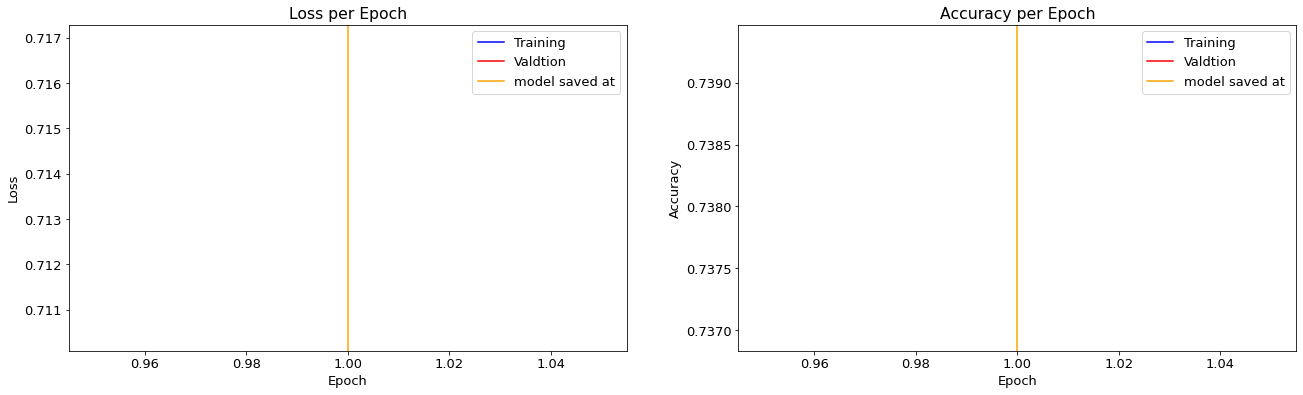

In [39]:
mosel_saved_at_ep =log_acc['ACC_Valdtion'].argmax()+1
fig,ax=plt.subplots(1,2,figsize = (22,6))
ax[0].plot(log_loss['Epochs'], log_loss['loss_Training'],label = "Training",color = 'blue')
ax[0].plot(log_loss['Epochs'], log_loss['loss_Valdtion'],label = "Valdtion",color = 'red')
ax[0].axvline(x=mosel_saved_at_ep,label = "model saved at" ,color = 'orange')
ax[0].set_title("Loss per Epoch") ,ax[0].legend() #,font ={'weight' : 'bold'}
ax[0].set_xlabel("Epoch") #,font ={'weight' : 'bold'}
ax[0].set_ylabel("Loss")#,font ={'weight' : 'bold'}

ax[1].plot(log_acc['Epochs'], log_acc['ACC_Training'],label = "Training",color = 'blue')
ax[1].plot(log_acc['Epochs'], log_acc['ACC_Valdtion'],label = "Valdtion",color = 'red')
ax[1].axvline(x=mosel_saved_at_ep,label = "model saved at",color = 'orange')
ax[1].set_title("Accuracy per Epoch")#,font ={'weight' : 'bold'}
#plt.ylim(.88,1) , 
ax[1].legend()
ax[1].set_xlabel("Epoch")#,font ={'weight' : 'bold'}
ax[1].set_ylabel("Accuracy")#,font ={'weight' : 'bold'}
plt.show()


In [37]:
best_model = copy.deepcopy(model)

state = torch.load("Best_model_on_valdtion.pt")
best_model.state_dict = state
best_model  = best_model.to(device)
optimizer.load_state_dict(state['optimizer'])


Accuracy : 0.7389244915018112 ,Error:0.26107550849818895 


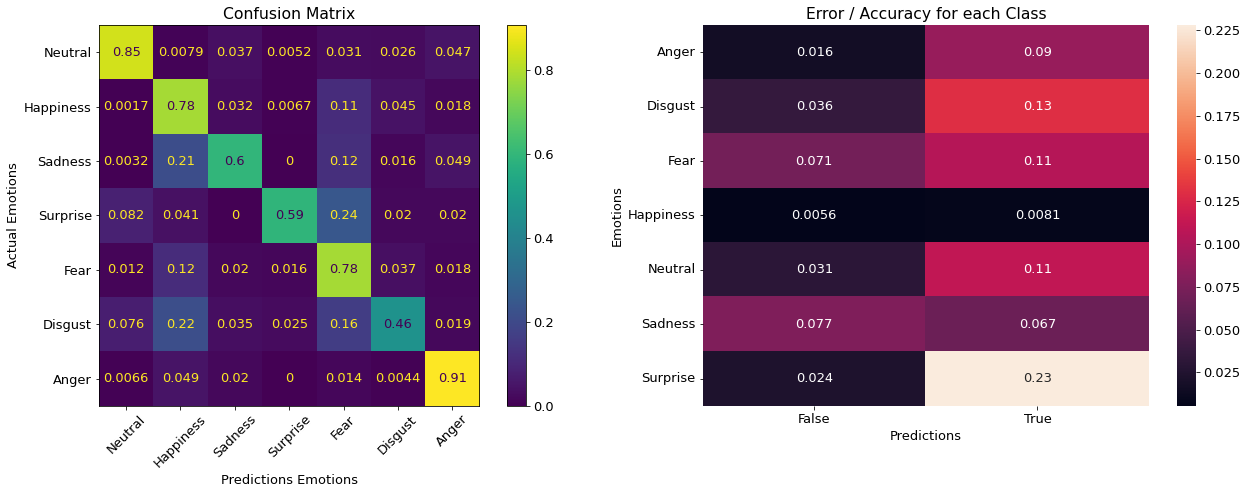

In [38]:
 model_data_montor(loader_val , 'best_model' )